# **Introducción**

En el siguiente cuaderno se muestra la aplicación del filtro de imagenes "Contraste" comparando las ejecuciones mediante CPU y GPU. Para aplicar un valor de contraste a una imagen, debemos calcular un factor con la siguiente fórmula: 

<center>$ Factor= (259 * (Contraste+255)) / (255 * (259-Contraste)) $</center>

Con el valor obtenido, se debe aplicar a cada pixel (rojo, verde y azul) de la imagen.



# **Armado del ambiente**
2.1 Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

2.2 Para la ejecución GPU, se debe instalar en el cuaderno en componente CUDA para python.

In [14]:
#@title ## -Seleccionar Imagen a aplicar filtro
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/SOA-1C-2021/HPC/blob/main/Cataratas_de_Iguazu.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/SOA-1C-2021/HPC/blob/main/Cataratas_de_Iguazu.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg


--2021-06-30 00:58:28--  https://github.com/SOA-1C-2021/HPC/blob/main/Cataratas_de_Iguazu.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SOA-1C-2021/HPC/raw/main/Cataratas_de_Iguazu.jpg [following]
--2021-06-30 00:58:28--  https://github.com/SOA-1C-2021/HPC/raw/main/Cataratas_de_Iguazu.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SOA-1C-2021/HPC/main/Cataratas_de_Iguazu.jpg [following]
--2021-06-30 00:58:28--  https://raw.githubusercontent.com/SOA-1C-2021/HPC/main/Cataratas_de_Iguazu.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

In [2]:
#@title ## -Instalación de Paquete (aplica para la ejecución GPU)
#@markdown ---

!pip install pycuda


# Desarrollo CPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Tiempo de conversión de imagen: 13790.505 [ms]
Tiempo Total: 13865.463 [ms]


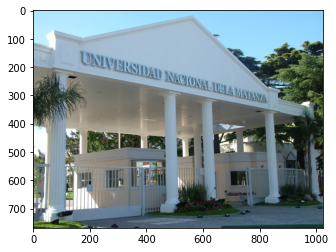

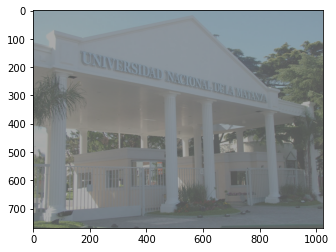

In [11]:
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# Muestro la imagen antes de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Cambiar a un parametro!!!
contraste = -128

# Calcular factor a aplicar en la formula de CONTRASTE
factor = (259*(contraste+255)) / (255*(259-contraste))

# Convierto la imagen según el valor de contraste ingresado por parámetro
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    pixelrojo, pixelverde, pixelazul = img_pic_cpu[y][x]

    nvopixelrojo = (factor*(pixelrojo-128) + 128)
    nvopixelverde = (factor*(pixelverde-128) + 128)
    nvopixelazul = (factor*(pixelazul-128) + 128)
    img_picR_cpu[y][x] = [nvopixelrojo, nvopixelverde, nvopixelazul]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )


---
# Desarrollo GPU

Imagen del filtro: imagen.jpg -RGB- [1023, 682]
Thread: [ 16 , 19  ], Bloque : [ 64 , 36 ]
Total de Thread: [ 1024 , 684  ]  =  700416
Tiempo TOTAL:  90.586 [ms]
Tiempo GPU  :  0.389 [ms]


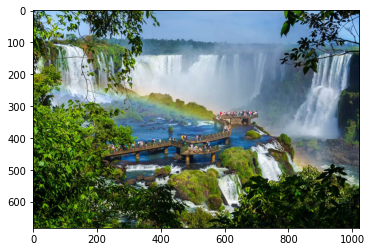

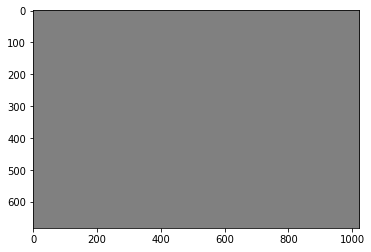

In [15]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

#cambiar a un parametro!!!
contraste = 128

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule(""" 
__global__ void kernel_img( int contraste, int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float factor = 0.0;
  float nvopixelrojo;
  float nvopixelverde;
  float nvopixelazul;

  // Calcular factor a aplicar en la formula de CONTRASTE
  factor = (259*(contraste+255)) / (255*(259-contraste));
  
  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el nuevo color para el pixel a partir de los componentes.
    nvopixelrojo =  (float)(factor*(img_O[((idx+(idy*ancho))*3)+0]-128) + 128); //Rojo
    nvopixelverde = (float)(factor*(img_O[((idx+(idy*ancho))*3)+1]-128) + 128); //Verde
    nvopixelazul =  (float)(factor*(img_O[((idx+(idy*ancho))*3)+2]-128) + 128); //Azul

    // Escribo el nuevo color del pixel.
    img_R[(idx+(idy*ancho))*3+0] = (int) nvopixelrojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) nvopixelverde;
    img_R[(idx+(idy*ancho))*3+2] = (int) nvopixelazul;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(contraste), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

---
# Métricas


# Conclusiones

# Bibliografía